<a href="https://colab.research.google.com/github/Korniev/Data-Sciense/blob/main/hw_10/hw_10.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Частина 2

В цій частині ми знову будемо працювати з датасетом fasion_mnist.

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, що використовує VGG16 в якості згорткової основи.

Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Під час навчання використовуйте прийоми донавчання та виділення ознак.

Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

Як завжди, почнемо з імпортів потрібних бібліотек:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras import optimizers, losses
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

Слідуючи з умови задвання, для наших цілей в якості згорткової основи ми скористаємося мережею VGG16, яка була навчена на даних ImageNet.

Давайте імпортуємо нашу модель, щоб створити основу згортки на базі VGG16:

In [3]:
conv_vgg16_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))


58889256/58889256 [==============================] - 0s 0us/step


Супер, тепер ми можемо розширити нашу модель, додавши кастомні повнозвʼязні шари, для того, щоб наша модель адекватно навчалась на нашому датасеті:

In [21]:
conv_vgg16_base.trainable = False

model = Sequential([
   conv_vgg16_base,
   Flatten(),
   Dense(512, activation='relu'),
   Dropout(0.2),
   Dense(10, activation="softmax"),
])

Після додавання верхніх шарів, модель потрібно скомпілювати, вказавши оптимізатор, функцію втрат і метрики:

In [22]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

Подивимось на архітектуру нашої моделі:

In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Як бачимо, в нас 14714688 не тренерованих параметрів, які ми відключили шляхов додавання рядку conv_vgg16_base.trainable = False

Тепер коли модель в нас готова, займемось підготовкою даних. Для початку завантажимо датасет і подивимось на його вміст:

In [7]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

4422102/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

Ми вже знаємо, що кожному зображенню відповідає одна мітка. Оскільки назви класів не включено до набору даних, збережемо їх тут, щоб використати пізніше при побудові зображень. Збережемо їх в ліст class_names:

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Щоб переконатися, що дані в правильному форматі, і що ми готові до побудови та навчання мережі, покажемо перші 25 зображень з навчального набору і покажемо назву класу під кожним зображенням.

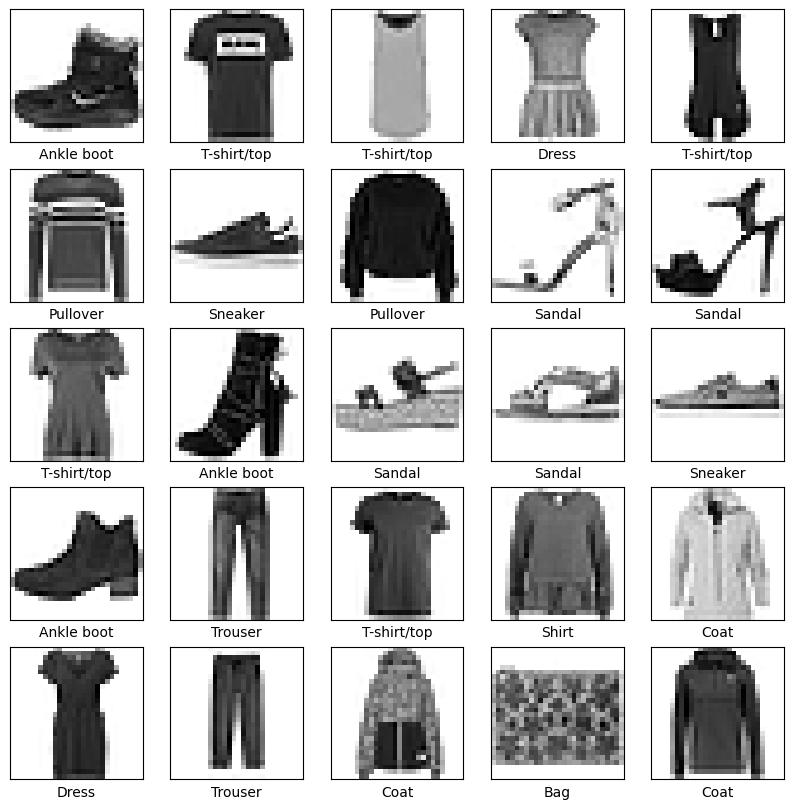

In [9]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

Зараз нам потрібно попрацювати з даними і підготувати їх для навчання.

Дана попередньонавчена згорткова VGG16 модель по-нормальному повинна приймати зображення у форматі 150x150 або 224x224 пікселів.
Але по ресурсам памʼяті ми не можемо перевести у розмір 150х150. Мінімальний формат, який приймає наша VGG16 це 32х32х3. Для цього переведемо наш формат 28х28х1 на 32х32х3 як ми задали параметр вхідного формату при імпорті даної моделі. Також потрібно змінити зображення з одного кольорового каналу (чорно-білі) на три кольорові канали:

In [10]:
train_images_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=3)
test_images_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=3)

In [11]:
train_images = np.array([np.resize(img, (32, 32, 3)) for img in train_images_rgb])
test_images = np.array([np.resize(img, (32, 32, 3)) for img in test_images_rgb])

І нормалізуємо наші нові отримані дані:

In [12]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

Тепер ми можемо навчати модель, використовуючи тренувальні дані:

In [24]:
history = model.fit(train_images, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
 19/375 [>.............................] - ETA: 9:16 - loss: 2.3318 - accuracy: 0.1238

KeyboardInterrupt: 

Як на мене, то 70% точність на тренувальній і 74% на валідаційні то є дуже поганим результатим. Нам потрібно покращувати модель.
Одна з можливостей це зробити - це застосувати аугментацію для тренувлаьних даних, так як аугментація створює більш різноманітний тренувальний набір.

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator()

Оскільки ми вже нормалізували зображення, можна використати .flow() метод для створення генераторів:

In [21]:
train_generator = train_datagen.flow(
        train_images,
        y_train,
        batch_size=128)

validation_generator = test_datagen.flow(
        test_images,
        y_test,
        batch_size=128)


Тепер ми готові приступити до навчання моделі з використанням цих генераторів, які задали вище:

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 256,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(test_images) // 256
)


Epoch 1/20
234/234 [==============================] - 21s 89ms/step - loss: 0.9709 - acc: 0.6450 - val_loss: 0.8479 - val_acc: 0.6919
Epoch 2/20
234/234 [==============================] - 20s 86ms/step - loss: 0.9675 - acc: 0.6438 - val_loss: 0.8450 - val_acc: 0.6992
Epoch 3/20
234/234 [==============================] - 20s 84ms/step - loss: 0.9634 - acc: 0.6454 - val_loss: 0.8334 - val_acc: 0.7047
Epoch 4/20
234/234 [==============================] - 20s 87ms/step - loss: 0.9636 - acc: 0.6468 - val_loss: 0.8361 - val_acc: 0.6991
Epoch 5/20
234/234 [==============================] - 22s 93ms/step - loss: 0.9576 - acc: 0.6462 - val_loss: 0.8370 - val_acc: 0.7020
Epoch 6/20
234/234 [==============================] - 21s 90ms/step - loss: 0.9566 - acc: 0.6487 - val_loss: 0.8306 - val_acc: 0.7026
Epoch 7/20
234/234 [==============================] - 20s 85ms/step - loss: 0.9488 - acc: 0.6522 - val_loss: 0.8205 - val_acc: 0.7079
Epoch 8/20
234/234 [==============================] - 21s 88ms

Давайте візуалізуємо отримані дані шляхом відображення отриманих результатів на графіках

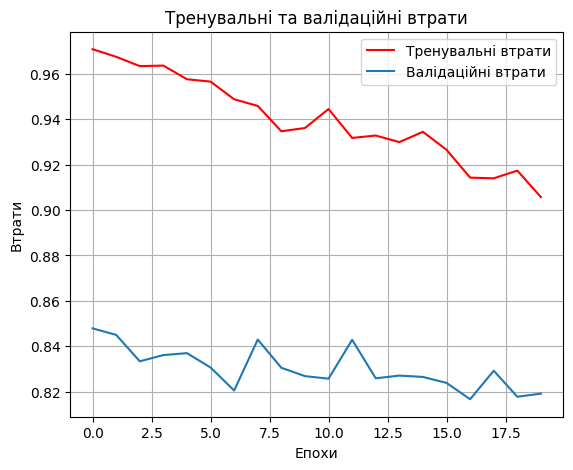

In [23]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

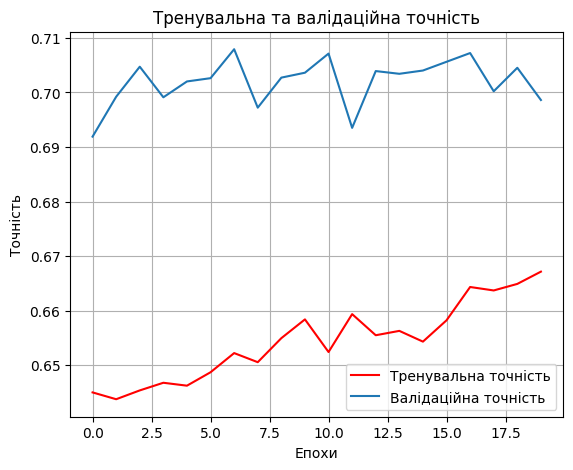

In [26]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_acc'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()

Дуже погано.. Навіть гірші результати, ніж були до аугментаціїї даних...

Давайте спробуємо зробити донавчання, розморозивши частину частину згорткової основи:

In [1]:
conv_vgg16_base.trainable = False

for layer in conv_vgg16_base.layers[:-4]:
    layer.trainable = False
for layer in conv_vgg16_base.layers[-4:]:
    layer.trainable = True

model = Sequential([
   conv_vgg16_base,
   Flatten(),
   Dropout(0.2),
   Dense(256, activation="relu"),
   Dropout(0.2),
   Dense(10, activation="softmax"),
])

NameError: name 'conv_vgg16_base' is not defined